In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import sys

In [ ]:
from google.colab import drive # 추가된 부분
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deepface # 추가된 부분

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=1579a70985b7a6330ae3fcfbe841a476397cabd6da5b0193a0b2220a638094ca
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate,Dropout,ZeroPadding2D
from tensorflow.keras.layers import Flatten, AveragePooling2D,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Conv2D,Dropout,Lambda,PReLU, LeakyReLU,BatchNormalization
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as k
leaky_relu = LeakyReLU(alpha=0.01)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import add, Activation
#from tensorflow.keras.applications import Inceptio
from deepface.basemodels import Facenet,VGGFace

In [ ]:
############## create_model ##################

In [ ]:
vgg = VGGFace.baseModel() # 36 layers
vgg.summary()

In [ ]:
! pip install gdown # 추가된 부분

In [ ]:
! gdown https://drive.google.com/uc?id=1yboiKXgQghW_9k4aYlLOLH1LC_x8RCvn # 추가된 부분. Face_recognition에서 불러왔던 가중치를 여기에 불러옴

In [ ]:
vgg.load_weights('/content/vgg_face_weights.h5')

In [ ]:
size = 224
shape = (size,size,3)

In [ ]:
cnt = 0
# print(len(vgg.layers))
for lyer in vgg.layers: # 35, 36층은 Con2d, flatten인데 실질적으로 이중에서 파라미터가 있는 층은 Conv2D라서 Conv2D만 학습
    if cnt==35: # vggface 학습 동결
        lyer.trainable= True
        lyer.activation= tf.keras.layers.Activation('tanh')
        # print(lyer)
    else:
        lyer.trainable =False
    cnt = cnt+1
# print(vgg.layers[-2])
# Remove Last Softmax layer and get model upto last flatten layer with outputs 2622 units
vgg_face = Model(inputs=vgg.layers[0].input, outputs=vgg.layers[-2].output)

In [ ]:
def create_model():
    inputs = Input(shape)
    #inputs = BatchNormalization(axis= -1)(inputs)
    outputs = vgg_face(inputs)
    # flatten layer 삭제

    model = Model(inputs,outputs)
    print(vgg_face.summary())
    print(model.summary())
    return model

In [ ]:
extractor = create_model() # representation vector extractor

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_input (Input  [(None, 224, 224, 3)]    0         
 Layer)                                                          
                                                                 
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                             

In [ ]:
imgA = Input(shape=shape)
imgB = Input(shape=shape)
featA = extractor(imgA) # vggface의 마지막 flatten의 결과 represntation vector(feature vector) 추출
featB = extractor(imgB)
#comb = Concatenate()([featA,featB])

In [ ]:
def euclidean_distance(vectors): # imgA와 imgB의 representation vector 거리 비교
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

# def findCosineDistance(vectors): # 코사인 유사도 측정, but 여러 오류 발생. 따로 더 시도해봐야 할 듯
#     (featA, featB) = vectors
#     a = k.dot(k.transpose(featA), featB)
#     b = k.sum(featA*featB)
#     c = k.sum(featA*featB)
#     return 1 - (a / (k.sqrt(b) * k.sqrt(c)))

distance = Lambda(euclidean_distance)([featA, featB])
# distance = Lambda(findCosineDistance)([featA, featB])
print(distance)
outputs = Dense(1, activation="sigmoid", name = 'ddd')(distance) # sigmoid로 확률화
model = Model(inputs=[imgA, imgB], outputs=outputs)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='lambda/Sqrt:0', description="created by layer 'lambda'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 2622)    

In [ ]:
############## train data ##################

In [ ]:
def resz3(h,w,img):
    hz = np.zeros((h,w,3))
    for i in range(3):

        hz[:,:,i] = cv.resize(img[:,:,i],(w,h))

    return hz

In [ ]:
datadir = '/content/drive/MyDrive/Colab Notebooks/Face_Recognition/Images_crop'
classes = [i for i in os.listdir(datadir)]
# print(classes)
# classes = classes[:400]
# print(classes)
training=[]
for clas in classes:
    Path=os.path.join(datadir,clas)
    # print(Path)
    label=classes.index(clas)
    # print(label)
    for img in (os.listdir(Path)):
        imgarray= cv.imread(os.path.join(Path,img))
        newimg =  resz3(size,size,imgarray)
        #newimg=cv.resize(imgarray,(160,160))
        training.append([newimg,label])
import random
random.shuffle(training)
x=[] # train data
y=[] # train label
for fea,labl in training:
    x.append(fea)
    y.append(labl)
x=np.array(x)
y=np.array(y)
#y = tf.one_hot(y,2)
print(x.shape)
print(y)

(1945, 224, 224, 3)
[251   3 364 ... 322 384 363]


In [ ]:
print(y.shape)
print(len(y))
print(np.where(y==342)) # shuffle

(1945,)
1945
(array([  20,  558,  660, 1282, 1302]),)


In [ ]:
############## pos-neg pair ratio adjustment ##################

In [ ]:
# Original Code

In [ ]:
def preprocess_pairs(images, labels,classes):
    targets = [j for j in range(len(classes))]
    label_indices = {}
    for label in targets:
        label_indices.setdefault(label,[index for index, curr_label in enumerate(labels) if label == curr_label]) # image들의 각 index가 어느 label(class)에 속하는지 정의
        # print(label_indices)
        #list comprehension

    pimages = []
    plabels = []
    for i, image in enumerate(images):
        pos_indices = label_indices.get(labels[i]) # i번째 image와 동일한 class에 속하는 모든 index를 꺼내옴
        pos_image = images[np.random.choice(pos_indices)] # i번째 image와 동일한 class 속하는 index 들 중에 random으로 꺼내온 index의 이미지를 저장
        pimages.append((image, pos_image)) # i번째 image와 i번째 image와 동일한 class를 가진 다른 random image로 이루어진 pair(양성 image pair)
        plabels.append(1) # 양성 image pair는 1로 labeling

        neg_indices = np.where(labels != labels[i]) # i번째 image와 다른 class 속하는 모든 index를 꺼내옴
        neg_image = images[np.random.choice(neg_indices[0])] # 왜 다른 class에 속하는 image들 중에 0번째 image만 가져오는 거지???->어차피 다르다는 것만 학습하면 돼서?
        pimages.append((image, neg_image)) # i번째 image와 i번째 image와 다른 class에 속하는 image로 이루어진 pair(음성 image pair)
        plabels.append(0) # 음성 image pair는 0으로 labeling


    return np.array(pimages), np.array(plabels)

In [ ]:
# Modified Code

In [ ]:
def preprocess_pairs(images, labels,classes):
    targets = [j for j in range(len(classes))]
    label_indices = {}
    for label in targets:
        label_indices.setdefault(label,[index for index, curr_label in enumerate(labels) if label == curr_label]) # image들의 각 index가 어느 label(class)에 속하는지 정의
        # print(label_indices)
        #list comprehension
    counts=np.zeros(labels.shape)
    r_f=8 # number of pos pair that you want(0~10)

    pimages = []
    plabels = []
    for i, image in enumerate(images):

        if r_f<5: # pos pair < neg pair
            if counts[labels[i]]<2*r_f:
                pos_indices = label_indices.get(labels[i])
                pos_image = images[np.random.choice(pos_indices)]
                pimages.append((image, pos_image))
                plabels.append(1)

                counts[labels[i]]+=1
            else:
                neg_indices = np.where(labels != labels[i])
                neg_image = images[np.random.choice(neg_indices[0])]
                pimages.append((image, neg_image))
                plabels.append(0)

                counts[labels[i]]+=1

            neg_indices = np.where(labels != labels[i])
            neg_image = images[np.random.choice(neg_indices[0])]
            pimages.append((image, neg_image))
            plabels.append(0)

            counts[labels[i]]+=1

        elif r_f>5: # pos pair > neg pair
            pos_indices = label_indices.get(labels[i])
            pos_image = images[np.random.choice(pos_indices)]
            pimages.append((image, pos_image))
            plabels.append(1)

            counts[labels[i]]+=1

            if counts[labels[i]]>2*(10-r_f): # 10은 총 pair 수(각 인물 당 이미지 개수*2)
                pos_indices = label_indices.get(labels[i])
                pos_image = images[np.random.choice(pos_indices)]
                pimages.append((image, pos_image))
                plabels.append(1)

                counts[labels[i]]+=1
            else:
                neg_indices = np.where(labels != labels[i])
                neg_image = images[np.random.choice(neg_indices[0])]
                pimages.append((image, neg_image))
                plabels.append(0)

                counts[labels[i]]+=1

        else: # pos pair = neg pair
            pos_indices = label_indices.get(labels[i])
            pos_image = images[np.random.choice(pos_indices)]
            pimages.append((image, pos_image))
            plabels.append(1)

            neg_indices = np.where(labels != labels[i])
            neg_image = images[np.random.choice(neg_indices[0])]
            pimages.append((image, neg_image))
            plabels.append(0)


    return np.array(pimages), np.array(plabels)

In [ ]:
pairs , labels = preprocess_pairs(x,y,classes)
print(len(pairs)) # 음성, 양성 두 개 씩이라 x2
print(pairs.shape)
print(labels)
print(labels.shape)

3890
(3890, 2, 224, 224, 3)
[1 0 1 ... 1 1 1]
(3890,)


In [ ]:
# 비율 확인
print(list(labels).count(1))
print(list(labels).count(0))

3112
778


In [ ]:
(sys.getsizeof(pairs)/1024)/1024

8934.84391784668

In [ ]:
show = 2
img1,img2 = pairs[show]

1


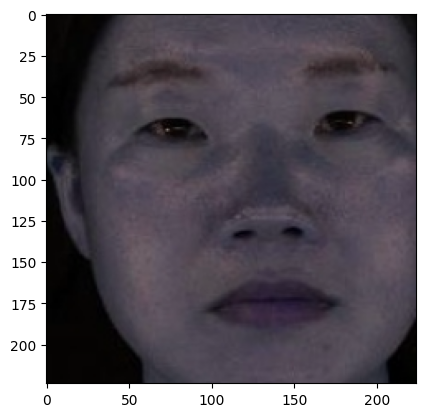

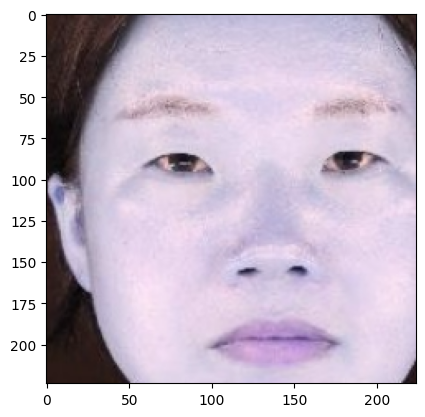

In [ ]:
print(labels[show])
plt.imshow((img1.astype(np.uint8)))
plt.show()
plt.imshow((img2.astype(np.uint8)))
plt.show()

In [ ]:
############## model training ##################

In [ ]:
import pickle

In [ ]:
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,LearningRateScheduler
# callback은 모델의 학습 과정에서 특정 이벤트가 발생할 때 호출되는 함수의 집합
# tensorboard는 tf의 시각화 도구. 모델의 학습 과정과 성능을 시각적으로 모니터링
# EarlyStopping은 지정된 조건을 충족할 때 학습을 조기 종료하는 기능
import datetime
logg = "logs3"
tfcallback = TensorBoard(log_dir=logg) # log_dir는 로그 파일의 저장 위치를 지정

In [ ]:
############# lr scheduler

In [ ]:
import math

# learning rate scheduler
def cosine_lr(epoch, lr):
    initial_lr = 0.01
    end_lr = 0.001
    epochs = 200
    cos_lr = 0.5 * (1 + math.cos(math.pi * epoch / epochs)) * (initial_lr - end_lr) + end_lr
    return cos_lr

In [ ]:
cosine_lr_callback = LearningRateScheduler(cosine_lr)
callbacks = [cosine_lr_callback]

In [ ]:
model.compile(loss="binary_crossentropy", optimizer= Adam(0.001), metrics=["accuracy"])

In [ ]:
############# lr scheduler use

In [ ]:
model.fit([pairs[:, 0], pairs[:, 1]], labels[:],validation_split=0.2,batch_size = 32,
          epochs=200,verbose=2,callbacks=callbacks)

Epoch 1/200
98/98 - 82s - loss: 2.4336 - accuracy: 0.4682 - val_loss: 0.7118 - val_accuracy: 0.7404 - lr: 0.0100 - 82s/epoch - 839ms/step
Epoch 2/200
98/98 - 50s - loss: 0.7469 - accuracy: 0.6009 - val_loss: 0.3351 - val_accuracy: 0.9075 - lr: 0.0100 - 50s/epoch - 513ms/step
Epoch 3/200
98/98 - 50s - loss: 0.6151 - accuracy: 0.6472 - val_loss: 0.3274 - val_accuracy: 0.9460 - lr: 0.0100 - 50s/epoch - 514ms/step
Epoch 4/200
98/98 - 50s - loss: 0.5677 - accuracy: 0.7214 - val_loss: 0.3483 - val_accuracy: 0.9434 - lr: 0.0100 - 50s/epoch - 514ms/step
Epoch 5/200
98/98 - 50s - loss: 0.5330 - accuracy: 0.7558 - val_loss: 0.2569 - val_accuracy: 0.9833 - lr: 0.0100 - 50s/epoch - 514ms/step
Epoch 6/200
98/98 - 50s - loss: 0.5232 - accuracy: 0.7606 - val_loss: 0.2196 - val_accuracy: 0.9936 - lr: 0.0100 - 50s/epoch - 513ms/step
Epoch 7/200
98/98 - 50s - loss: 0.5252 - accuracy: 0.7551 - val_loss: 0.2234 - val_accuracy: 0.9949 - lr: 0.0100 - 50s/epoch - 512ms/step
Epoch 8/200
98/98 - 50s - loss: 0.

KeyboardInterrupt: ignored

In [ ]:
############# lr scheduler not use

In [ ]:
model.fit([pairs[:, 0], pairs[:, 1]], labels[:],validation_split=0.2,batch_size = 32, # training data는 pairs[:,0], pairs[:,1] 두 개. label은 labels[:]
          epochs=100,verbose=2)

Epoch 1/100
97/97 - 83s - loss: 2.4113 - accuracy: 0.5447 - val_loss: 0.6119 - val_accuracy: 0.7019 - 83s/epoch - 858ms/step
Epoch 2/100
97/97 - 49s - loss: 0.6827 - accuracy: 0.6444 - val_loss: 0.6504 - val_accuracy: 0.6852 - 49s/epoch - 505ms/step
Epoch 3/100
97/97 - 49s - loss: 0.7009 - accuracy: 0.6467 - val_loss: 0.6120 - val_accuracy: 0.7032 - 49s/epoch - 506ms/step
Epoch 4/100
97/97 - 49s - loss: 0.6790 - accuracy: 0.6554 - val_loss: 0.6379 - val_accuracy: 0.6748 - 49s/epoch - 506ms/step
Epoch 5/100
97/97 - 49s - loss: 0.7004 - accuracy: 0.6489 - val_loss: 0.5898 - val_accuracy: 0.7174 - 49s/epoch - 506ms/step
Epoch 6/100
97/97 - 49s - loss: 0.6563 - accuracy: 0.6718 - val_loss: 0.5808 - val_accuracy: 0.7329 - 49s/epoch - 506ms/step
Epoch 7/100
97/97 - 49s - loss: 0.6818 - accuracy: 0.6631 - val_loss: 0.5989 - val_accuracy: 0.7174 - 49s/epoch - 505ms/step
Epoch 8/100
97/97 - 49s - loss: 0.6971 - accuracy: 0.6502 - val_loss: 0.5668 - val_accuracy: 0.7432 - 49s/epoch - 506ms/step


In [ ]:
keyss = model.history.history # 모델의 학습 이력 정보(history)를 가져옴
nn = len(keyss['loss'])

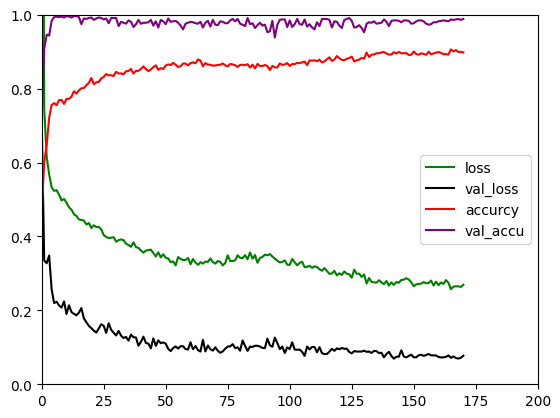

In [ ]:
plt.plot(np.arange(nn),keyss['loss'],color='green',label='loss')
plt.legend() # legend는 그래프의 범례 표시
plt.plot(np.arange(nn),keyss['val_loss'],color='black',label = 'val_loss')
plt.legend()
plt.plot(np.arange(nn),keyss['accuracy'],color='red',label = 'accurcy')
plt.legend()
plt.plot(np.arange(nn),keyss['val_accuracy'],color='purple',label = 'val_accu')
plt.legend()
plt.xlim(0,200)
plt.ylim(0,1)
plt.show()

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks
vgg.save_weights('vgg_face_weights_sh_2.h5')

/content/drive/MyDrive/Colab Notebooks


In [ ]:
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
def l2_normalize(xx):
    return xx / np.sqrt(np.sum(np.multiply(xx, xx)))
def findEuclideanDistance(source_representation, test_representation):
    if type(source_representation) == list:
        source_representation = np.array(source_representation)

    if type(test_representation) == list:
        test_representation = np.array(test_representation)

    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [ ]:
############## model testing ##################

['박명수', '유재석', '강호동']
해린_3.jpg


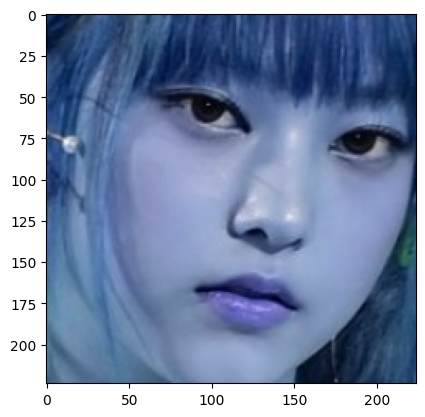

1/1 [==============================] - 0s 20ms/step


KeyboardInterrupt: ignored

In [ ]:
from scipy import spatial
datadir = '/content/drive/MyDrive/Colab Notebooks/Face_Recognition/Images_crop'
classes = [i for i in os.listdir(datadir)]
db = []
for clas in classes:
    path = os.path.join(datadir,clas)
    for img in os.listdir(path):
        img2= cv.imread(os.path.join(path,img))
        img2 = resz3(224,224,img2)
        #newimg=cv.resize(imgarray,(160,160))
        db.append(np.array(img2)) # db는 training images(15)
print(classes) # class를 얻기 위함
Path = '/content/drive/MyDrive/Colab Notebooks/Face_Recognition/Image_test_crop'

for img in (os.listdir(Path)):
    print(img)
    imgarray= cv.imread(os.path.join(Path,img))
    imgsc =  resz3(size,size,imgarray)
    plt.imshow((imgsc.astype(np.uint8)))
    plt.show()
    imgsc = imgsc.reshape(-1,size,size,3,1)
    f1 = extractor.predict(imgsc) # f1은 representation vector
    #f1 = l2_normalize(f1)
    #newimg=cv.resize(imgarray,(160,160))
    dist = []
    for imgref in db:                                           # training dataset 내 모든 data와 비교

        imgref = resz3(size,size,imgref)
        #plt.imshow((imgref.astype(np.uint8)))
        #plt.show()
        f2 = extractor.predict(imgref.reshape(-1,size,size,3,1))
        f1=f1.reshape((-1,))
        f2=f2.reshape((-1,))
        dis = spatial.distance.cosine(f1,f2) # training images와 test image 사이의 거리
        #f2 = l2_normalize(f2)
        #sum_squared = k.sum(k.square(f1 - f2), axis=1)
        #dis = k.sqrt(k.maximum(sum_squared,k.epsilon()))

        dist.append(dis)
    print(np.round(dist,9))
    print(y[np.argmin(dist)])                                    # training images 중 거리가 가장 작은 image의 index. 이 index가 속한 y(label) 출력



    #print(classes[np.argmin(dist)])